In [1]:
'''Retrieve all inputs executed in the current kernel section'''
%history

'''Retrieve all inputs executed in the current kernel section'''
%history


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import squarify

import warnings

In [3]:
print('Pandas version -> %s' % pd.__version__)
print('Numpy version -> %s' % np.__version__)

Pandas version -> 2.1.2
Numpy version -> 1.26.1


In [4]:
df_sales_data = pd.read_csv('sales_data_cleaned.csv', index_col='Unnamed: 0',
                                    dtype={  'InvoiceDate': 'string',
                                             'InvoiceMonth': 'category',
                                             'DayPart': 'category',
                                             'InvoiceNo': 'category',
                                             'CustomerID': 'string',
                                             'Country': 'category',
                                             'StockCode': 'category',
                                             'Quantity': 'int64',
                                             'UnitPrice': 'float64',
                                             'Revenue': 'float64'},
                                    parse_dates=['InvoiceDate'])

In [5]:
df_sales_data.head()

,InvoiceDate,InvoiceMonth,DayPart,InvoiceNo,CustomerID,Country,StockCode,Quantity,UnitPrice,Revenue
0,2010-12-01,2010-12,Morning,536365,17850,United Kingdom,85123A,6,2.55,15.30
1,2010-12-01,2010-12,Morning,536365,17850,United Kingdom,71053,6,3.39,20.34
2,2010-12-01,2010-12,Morning,536365,17850,United Kingdom,84406B,8,2.75,22.00
3,2010-12-01,2010-12,Morning,536365,17850,United Kingdom,84029G,6,3.39,20.34
4,2010-12-01,2010-12,Morning,536365,17850,United Kingdom,84029E,6,3.39,20.34


In [6]:
df_sales_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392688 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceDate   392688 non-null  datetime64[ns]
 1   InvoiceMonth  392688 non-null  category      
 2   DayPart       392688 non-null  category      
 3   InvoiceNo     392688 non-null  category      
 4   CustomerID    392688 non-null  string        
 5   Country       392688 non-null  category      
 6   StockCode     392688 non-null  category      
 7   Quantity      392688 non-null  int64         
 8   UnitPrice     392688 non-null  float64       
 9   Revenue       392688 non-null  float64       
dtypes: category(5), datetime64[ns](1), float64(2), int64(1), string(1)
memory usage: 21.4 MB


In [7]:
#color palette to keep the following plots harmonic

colors = sns.color_palette("tab20", 20)
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [8]:
#calculate the values for recency, frequency and monetary

df_recency = df_sales_data.groupby('CustomerID',as_index=False)['InvoiceDate'].max()
df_recency.columns = ['CustomerID', 'MaxDate']

recency = df_recency['MaxDate'].max()
df_recency['Recency'] = df_recency['MaxDate'].apply(lambda x: (recency - x).days)
df_recency = df_recency.drop('MaxDate', axis=1)

df_frequency = df_sales_data.groupby(['CustomerID'],as_index=False)['InvoiceNo'].nunique()
df_frequency.columns = ['CustomerID', 'Frequency']

df_monetary = df_sales_data.groupby('CustomerID',as_index=False)['Revenue'].sum()
df_monetary.columns = ['CustomerID', 'Monetary']

df_rfm = df_frequency.merge(df_recency, on='CustomerID')
df_rfm = df_rfm.merge(df_monetary, on='CustomerID')

In [9]:
#set scores based on recency, frequency and monetary values
df_rfm['r_score'] = pd.qcut(df_rfm['Recency'], 3, ['3','2','1']).astype(np.int64) 

df_rfm.loc[df_rfm['Frequency'] == 1, 'f_score'] = 1
df_rfm.loc[df_rfm['Frequency'] >= 2, 'f_score'] = 2
df_rfm.loc[df_rfm['Frequency'] >= 5, 'f_score'] = 3

df_rfm['m_score'] = pd.qcut(df_rfm['Monetary'], 3, ['1','2','3']).astype(np.int64) 

df_rfm['RFM'] = df_rfm['r_score'] + df_rfm['f_score'] + df_rfm['m_score']

In [10]:
#export_rfm_data
df_rfm[['CustomerID','Recency','Frequency','Monetary','r_score','f_score','m_score','RFM']].to_csv('customer_rfm.csv')

In [11]:
#categorize the customers based upon their RFM scores
categories_dict={
9: 'Champion',
8: 'Loyal',
7: 'Potencial Loyal',
6: 'Promissing',
5: 'Need Atention',
4: 'Sleeping',
3: 'Lost'
}

warnings.filterwarnings("ignore")

df_rfm['UserCategory'] = ''
for i in df_rfm.index:
    if df_rfm['RFM'][i] in categories_dict:
        score = df_rfm['RFM'][i]
        df_rfm['UserCategory'][i] = categories_dict[score]
        
warnings.filterwarnings("default")

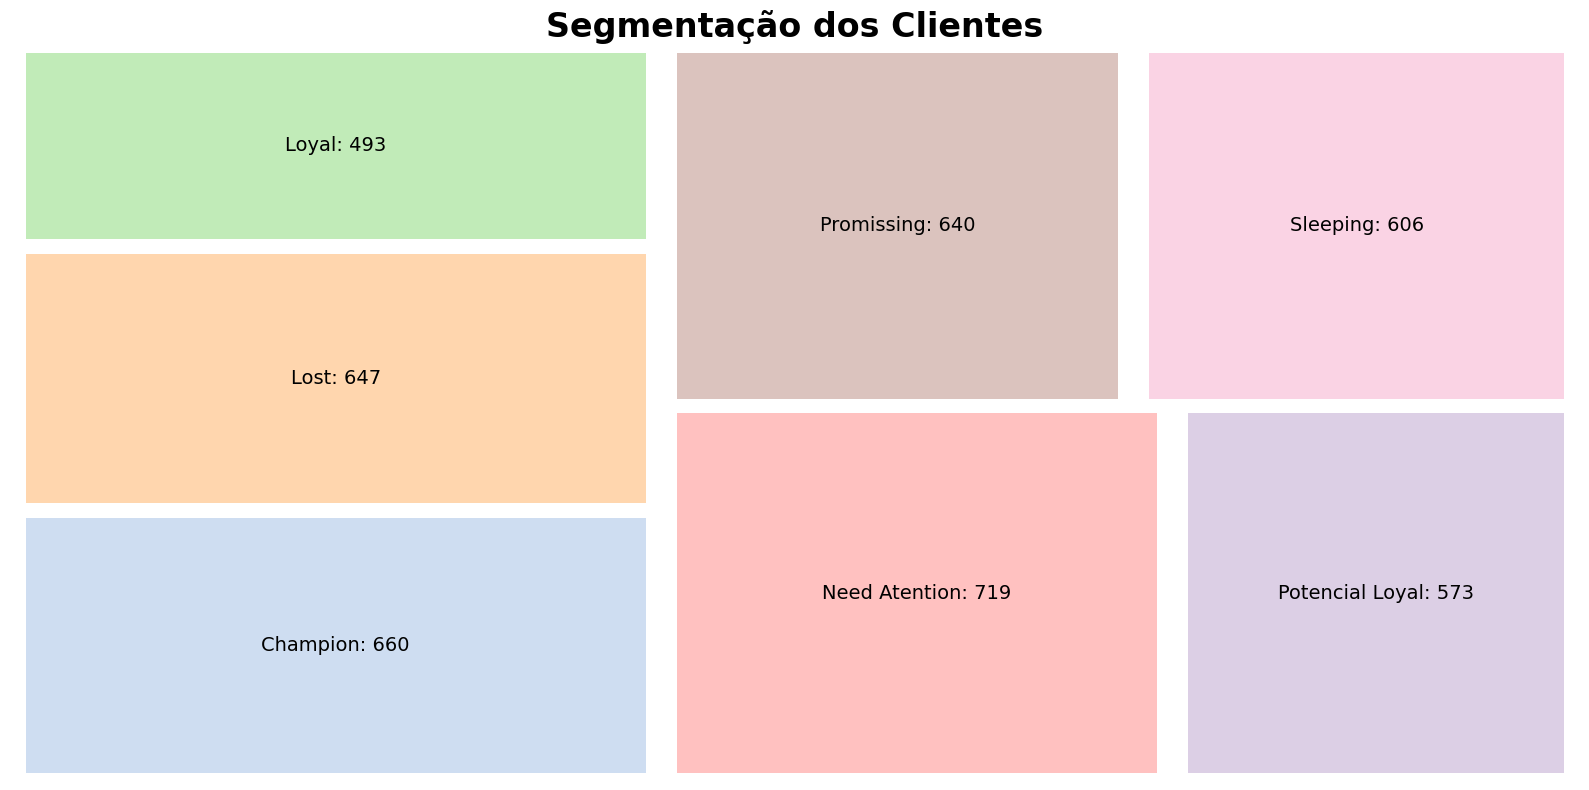

In [14]:
#group by customers by category
df_categorias = df_rfm.groupby(['UserCategory'], as_index=False)['CustomerID'].count()

labels = [*range(len(categories_dict))]
for category in range(len(categories_dict)):
    labels[category] = f'{df_categorias.iloc[category,0]}: {df_categorias.iloc[category,1]:,}'

# plot the segments 
fig, ax = plt.subplots(figsize=(16,8))
squarify.plot(sizes=df_categorias['CustomerID'],
              label=labels,
              color=colors[1::2],
              pad=True,
              alpha=0.6,
              text_kwargs={'fontsize': 14})

plt.title('Segmentação dos Clientes',
          fontsize=24,
          fontweight="bold")

plt.axis('off')
plt.tight_layout()

plt.show()

In [15]:
#merging frequency and monetary scores, so we can have a more usual chart
df_rfm['fm_score'] = (df_rfm['f_score'] + df_rfm['m_score'] ).astype(np.int64)

df_rfm['RFM*'] = df_rfm['r_score'].astype(str) + df_rfm['fm_score'].astype(str)

In [16]:
categories_dict = { '36': 'Champion',
                    '35': 'Loyal',
                    '34': 'Potencial Loyal',
                    '33': 'Promissing',
                    '32': 'New customer',
                    '26': 'Loyal',
                    '25': 'Loyal',
                    '24': 'Potencial Loyal',
                    '23': 'Promissing',
                    '22': 'Need Atention',
                    '16': "Can't Lose",
                    '15': "Can't Lose",
                    '14': 'Sleeping',
                    '13': 'Sleeping',
                    '12': 'Lost'}

warnings.filterwarnings("ignore")

df_rfm['UserCategory*'] = ''
for i in df_rfm.index:
    if df_rfm['RFM*'][i] in categories_dict:
        score = df_rfm['RFM*'][i]
        df_rfm['UserCategory*'][i] = categories_dict[score]
        
warnings.filterwarnings("default")

In [17]:
df_categorias = df_rfm.groupby(['UserCategory*'], as_index=False)['CustomerID'].count()
df_categorias = df_categorias.rename(columns={'UserCategory*': 'UserCategory'})

Text(1, 2, 'Lost: \n647')

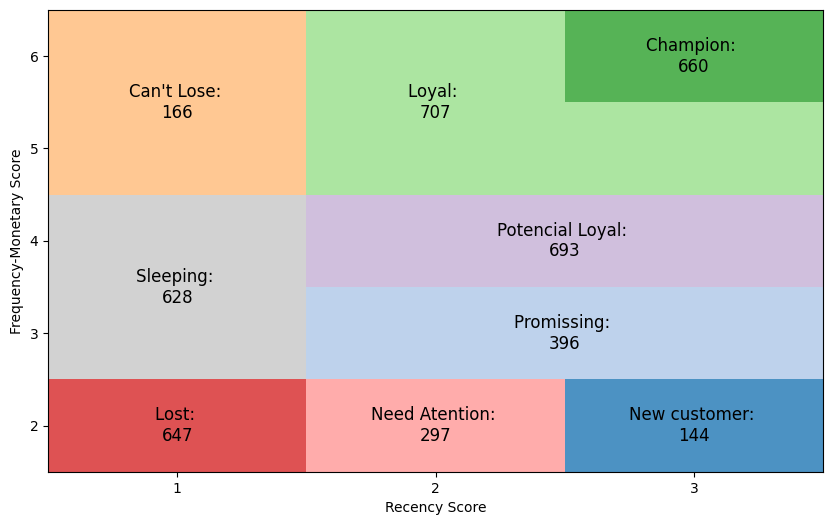

In [18]:
#plot a recency by frequency-monetary chart
fig, ax = plt.subplots(figsize=(10,6))

ax.set(xlim=(0.5, 3.5), ylim=(1.5, 6.5))

ax.set(xlabel='Recency Score')
ax.set(ylabel='Frequency-Monetary Score')

ax.set_xticks(ax.get_xticks()[1::2])

str1 = 'Champion: \n' + df_categorias.query('UserCategory == "Champion"')['CustomerID'].sum().astype(str)
str2 = 'Loyal: \n' + df_categorias.query('UserCategory == "Loyal"')['CustomerID'].sum().astype(str)
str3 = 'Potencial Loyal: \n' + df_categorias.query('UserCategory == "Potencial Loyal"')['CustomerID'].sum().astype(str)
str4 = 'Promissing: \n' + df_categorias.query('UserCategory == "Promissing"')['CustomerID'].sum().astype(str)
str5 = 'New customer: \n' + df_categorias.query('UserCategory == "New customer"')['CustomerID'].sum().astype(str)
str6 = 'Need Atention: \n' + df_categorias.query('UserCategory == "Need Atention"')['CustomerID'].sum().astype(str)
str7 = "Can't Lose: \n" + df_categorias.query('UserCategory == "Can\'t Lose"')['CustomerID'].sum().astype(str)
str8 = 'Sleeping: \n' + df_categorias.query('UserCategory == "Sleeping"')['CustomerID'].sum().astype(str)
str9 = 'Lost: \n' + df_categorias.query('UserCategory == "Lost"')['CustomerID'].sum().astype(str)

#Champion
ax.axhspan(ymin=5.5, ymax=6.5, xmin=(2/3), xmax=1, facecolor=colors[4], alpha=0.8)
ax.text(3,6,str1,ha='center', va='center', fontsize = 12)

#Loyal
ax.axhspan(ymin=4.5, ymax=5.5, xmin=(2/3), xmax=1, facecolor=colors[5], alpha=0.8)
ax.axhspan(ymin=4.5, ymax=6.5, xmin=(1/3), xmax=(2/3), facecolor=colors[5], alpha=0.8)
ax.text(2,5.5,str2,ha='center', va='center', fontsize = 12)

#Potencial Loyal
ax.axhspan(ymin=3.5, ymax=4.5, xmin=(1/3), xmax=1, facecolor=colors[9], alpha=0.8)
ax.text(2.5,4,str3,ha='center', va='center', fontsize = 12)

#Promissing
ax.axhspan(ymin=2.5, ymax=3.5, xmin=(1/3), xmax=1, facecolor=colors[1], alpha=0.8)
ax.text(2.5,3,str4,ha='center', va='center', fontsize = 12)

#New customer
ax.axhspan(ymin=1.5, ymax=2.5, xmin=(2/3), xmax=1, facecolor=colors[0], alpha=0.8)
ax.text(3,2,str5,ha='center', va='center', fontsize = 12)

#Need Atention
ax.axhspan(ymin=1.5, ymax=2.5, xmin=(1/3), xmax=(2/3), facecolor=colors[7], alpha=0.8)
ax.text(2,2,str6,ha='center', va='center', fontsize = 12)

#Can't Lose
ax.axhspan(ymin=4.5, ymax=6.5, xmin=0, xmax=(1/3), facecolor=colors[3], alpha=0.8)
ax.text(1,5.5,str7,ha='center', va='center', fontsize = 12)

#Sleeping
ax.axhspan(ymin=2.5, ymax=4.5, xmin=0, xmax=(1/3), facecolor=colors[15], alpha=0.8)
ax.text(1,3.5,str8,ha='center', va='center', fontsize = 12)

#Lost
ax.axhspan(ymin=1.5, ymax=2.5, xmin=0, xmax=(1/3), facecolor=colors[6], alpha=0.8)
ax.text(1,2,str9,ha='center', va='center', fontsize = 12)

In [25]:
#Convert Monetary values to log scale
warnings.filterwarnings("ignore")

df_KMeans_rfm = df_rfm[['CustomerID','Recency','Frequency','Monetary']]
df_KMeans_rfm['LogMonetary'] = np.log(df_KMeans_rfm['Monetary'])
df_KMeans_rfm = df_KMeans_rfm.drop(['Monetary'],axis=1)

warnings.filterwarnings("default")

df_KMeans_rfm.head(3)

,CustomerID,Recency,Frequency,LogMonetary
0,12346,325,1,11.253942
1,12347,2,7,8.368693
2,12348,75,4,7.494007


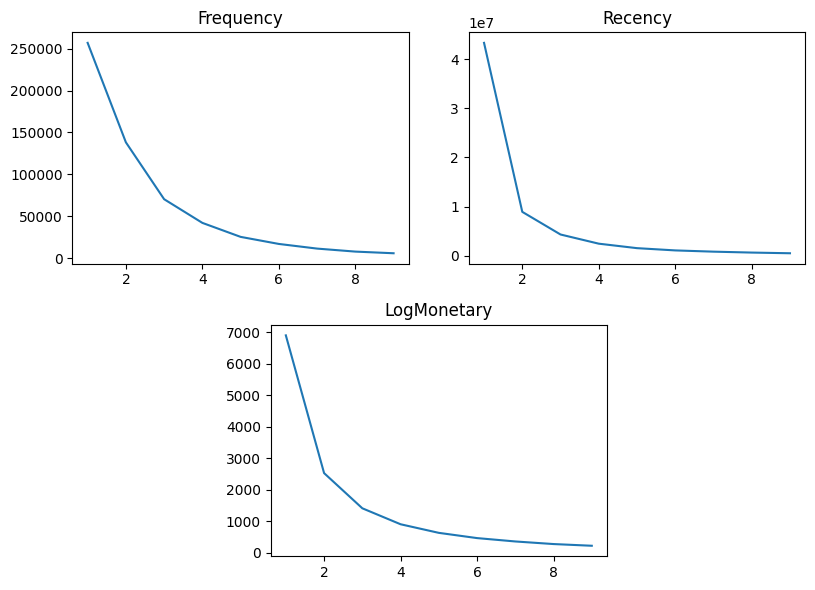

In [64]:
#FRM analysis with Kmeans to find data clusters
#How many clusters per column?
from sklearn.cluster import KMeans

aux=18
fig = plt.figure(figsize=(2*aux, 6))

ax = plt.subplot2grid((2,2*aux), (0,0), colspan=4)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=1000).fit(df_KMeans_rfm[['Frequency']])
    sse[k] = kmeans.inertia_ 
sns.lineplot(x=list(sse.keys()), y=list(sse.values()),color=colors[0])
ax.set_title('Frequency', fontsize=12)

ax = plt.subplot2grid((2,2*aux), (0,4), colspan=4)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=1000).fit(df_KMeans_rfm[['Recency']])
    sse[k] = kmeans.inertia_ 
sns.lineplot(x=list(sse.keys()), y=list(sse.values()),color=colors[0])
ax.set_title('Recency', fontsize=12)

ax = plt.subplot2grid((2,2*aux), (1,2), colspan=4)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=1000).fit(df_KMeans_rfm[['LogMonetary']])
    sse[k] = kmeans.inertia_ 
sns.lineplot(x=list(sse.keys()), y=list(sse.values()),color=colors[0])
ax.set_title('LogMonetary', fontsize=12)

plt.tight_layout()
plt.show()

In [65]:
# define function to put the clusters in order
def order_cluster(cluster_col, feature_col, df, ascending):
    '''
    This function takes in a column of cluster
    assignments and features used to assign the 
    cluster as strings, dataframe in which clusters
    are featured, and ascending argument. Returns 
    dataframe with clusters ordered from worst to best.
    Function by Allison Kelly from Towards Data Science
    '''
    
    df_new = df.groupby(cluster_col)[feature_col].mean().reset_index()
    df_new = df_new.sort_values(by=feature_col,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_col,'index']], on=cluster_col)
    df_final = df_final.drop([cluster_col],axis=1)
    df_final = df_final.rename(columns={"index":cluster_col})
    return df_final

In [69]:
# describe frequency clusters
frequency_kmeans = KMeans(n_clusters=4, n_init=10)
frequency_kmeans.fit(df_KMeans_rfm[['Frequency']])
df_KMeans_rfm['FrequencyCluster'] = frequency_kmeans.predict(df_KMeans_rfm[['Frequency']])
df_KMeans_rfm = order_cluster('FrequencyCluster', 'Frequency', df_KMeans_rfm, True)

df_KMeans_rfm.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3781.0,2.507802,1.712313,1.0,1.0,2.0,3.0,7.0
1,511.0,12.774951,4.978605,8.0,9.0,11.0,15.0,29.0
2,43.0,46.232558,18.198426,30.0,33.0,39.0,53.0,97.0
3,3.0,178.000000,46.936127,124.0,162.5,201.0,205.0,209.0


In [77]:
# describe recency clusters
recency_kmeans = KMeans(n_clusters=3, n_init=10)
recency_kmeans.fit(df_KMeans_rfm[['Recency']])
df_KMeans_rfm['RecencyCluster'] = recency_kmeans.predict(df_KMeans_rfm[['Recency']])
df_KMeans_rfm = order_cluster('RecencyCluster', 'Recency', df_KMeans_rfm, False)

df_KMeans_rfm.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,626.0,293.944089,45.109592,225.0,256.0,287.0,326.0,373.0
1,798.0,153.531328,38.096600,93.0,119.0,154.0,185.0,222.0
2,2914.0,31.855525,25.273459,0.0,10.0,25.0,51.0,92.0


In [78]:
# describe monetary clusters
revenue_kmeans = KMeans(n_clusters=4, n_init=10)
revenue_kmeans.fit(df_KMeans_rfm[['LogMonetary']])
df_KMeans_rfm['MonetaryCluster'] = revenue_kmeans.predict(df_KMeans_rfm[['LogMonetary']])
df_KMeans_rfm = order_cluster('MonetaryCluster', 'LogMonetary',df_KMeans_rfm,True)

df_KMeans_rfm.groupby('MonetaryCluster')['LogMonetary'].describe()

,count,mean,std,min,25%,50%,75%,max
MonetaryCluster,,,,,,,,
0,920.0,4.962894,0.520562,1.321756,4.730568,5.071570,5.333696,5.573408
1,1613.0,6.181323,0.343709,5.575646,5.872428,6.182746,6.481868,6.783008
2,1312.0,7.376994,0.369260,6.784615,7.049661,7.354170,7.676697,8.105848
3,493.0,8.831306,0.770803,8.113193,8.296382,8.593421,9.062513,12.543280


In [80]:
# sum overall RFM Score
df_KMeans_rfm['OverallScore'] = df_KMeans_rfm['RecencyCluster'] + df_KMeans_rfm['FrequencyCluster'] + df_KMeans_rfm['MonetaryCluster']
df_KMeans_rfm.groupby('OverallScore')[['Recency','Frequency','LogMonetary']].mean()

,Recency,Frequency,LogMonetary
OverallScore,,,
0,299.162162,1.057432,4.917023
1,231.915020,1.363636,5.538075
2,105.279503,1.639752,5.654901
3,55.465278,2.383681,6.404616
4,34.884488,4.271727,7.360320
5,26.336391,8.192661,8.014544
6,14.438127,14.889632,8.771642
7,4.048780,46.707317,10.094369
8,0.666667,178.000000,10.963660


In [81]:
#Set categories
df_KMeans_rfm['UserCategory'] = 'Bronze'
df_KMeans_rfm.loc[df_KMeans_rfm['OverallScore'] > 2, 'UserCategory'] = 'Silver'
df_KMeans_rfm.loc[df_KMeans_rfm['OverallScore'] > 4, 'UserCategory'] = 'Gold'
df_KMeans_rfm.loc[df_KMeans_rfm['OverallScore'] > 6, 'UserCategory'] = 'Platinum'

df_KMeans_rfm.groupby('UserCategory')[['Recency','Frequency','LogMonetary']].mean().reindex(['Bronze','Silver','Gold','Platinum'])

,Recency,Frequency,LogMonetary
UserCategory,,,
Bronze,180.865588,1.445551,5.482203
Silver,46.388161,3.216400,6.826127
Gold,20.653355,11.391374,8.376162
Platinum,3.818182,55.659091,10.153639


<IPython.core.display.Javascript object>


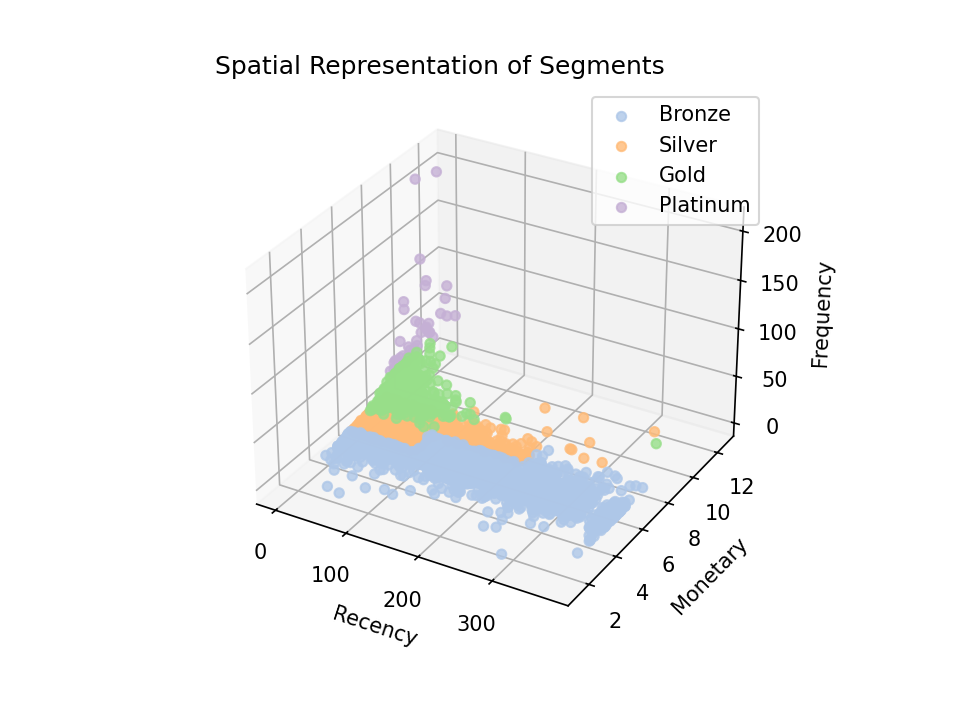

In [82]:
#plot 3d visualization
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

bronze = df_KMeans_rfm.query('UserCategory == "Bronze"')[['Frequency','Recency','LogMonetary']]
silver = df_KMeans_rfm.query('UserCategory == "Silver"')[['Frequency','Recency','LogMonetary']]
gold = df_KMeans_rfm.query('UserCategory == "Gold"')[['Frequency','Recency','LogMonetary']]
platinum = df_KMeans_rfm.query('UserCategory == "Platinum"')[['Frequency','Recency','LogMonetary']]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

g1 = (bronze['Frequency'].values, bronze['Recency'].values, bronze['LogMonetary'].values)
g2 = (silver['Frequency'].values, silver['Recency'].values, silver['LogMonetary'].values)
g3 = (gold['Frequency'].values, gold['Recency'].values, gold['LogMonetary'].values)
g4 = (platinum['Frequency'].values, platinum['Recency'].values, platinum['LogMonetary'].values)

data = [g1, g2, g3, g4]
palettes = [colors[1],colors[3],colors[5],colors[9]]
groups = ['Bronze','Silver','Gold','Platinum']

for data, palette, group in zip(data, palettes, groups):
    x, y, z = data
    ax.scatter(y, z, x, alpha=0.8, color=palette, label=group)

# Make legend
    ax.legend()
    ax.set_xlabel('Recency')
    ax.set_ylabel('Monetary')
    ax.set_zlabel('Frequency')
    ax.set_title('Spatial Representation of Segments', loc='left')
    plt.show();
    
%matplotlib inline